# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Mon Jun  9 00:39:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 40.6 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.0.1
    Uninstalling termcolor-3.0.1:
      Successfully uninstalled termcolor-3.0.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.9.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker

/tmp/ipykernel_19/4273075705.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2025-06-09 00:39:46.658998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749429586.849341      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749429586.903719      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Description of the data set

The dataset contains approximately 12,000 images divided into seven categories of waste, including paper, metal, cardboard, trash, glass, biological, and plastic.


# Data Preprcessing

In [5]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon WARNING @ 00:39:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:39:57] [setup] RAM Tracking...
[codecarbon INFO @ 00:39:57] [setup] CPU Tracking...
[codecarbon WARNING @ 00:39:59] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:39:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:39:59] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 00:39:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:39:59] [setup] GPU Tracking...
[codecarbon INFO @ 00:39:59] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:39:59] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

In [6]:
data_dir = '/kaggle/input/dwaste-data-v4'

Cleaning the working directory if there are any files in it

In [7]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [8]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 00:40:17] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:40:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:17] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 00:40:17] Energy consumed for all GPUs : 0.000101 kWh. Total GPU Power : 24.2448478711734 W
[codecarbon INFO @ 00:40:17] 0.000362 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:40:32] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:40:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:40:32] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 00:40:32] Energy consumed for all GPUs : 0.000202 kWh. Total GPU Power : 24.30614962183753 W
[codecarbon INFO @ 00:40:32] 0.000723 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:40:47] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20

'/kaggle/working/dataset'

In [9]:
data_dir  = '/kaggle/working/dataset'

In [10]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [11]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/paper/paper_2184.jpg is not an image
/kaggle/working/dataset/paper/paper_2184.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1678.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2779.jpg is not an image
/kaggle/working/dataset/paper/paper_2779.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2784.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_3119.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1433.jpg is not an image
/kaggle/working/dataset/paper/paper_1433.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_2088.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/cardboard/cardboard_313.jpg is not an image
/kaggle/working/dataset/cardboard/cardboard_313.jpg is a None, not accepted by TensorFlow
/

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [12]:
os.mkdir('data')

In [13]:
os.chdir('data')

In [14]:
os.getcwd()

'/kaggle/working/data'

In [15]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [16]:
os.chdir('/kaggle/working/')

In [17]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [18]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [19]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 11151 files [00:01, 6513.88 files/s]


In [20]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [21]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [22]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

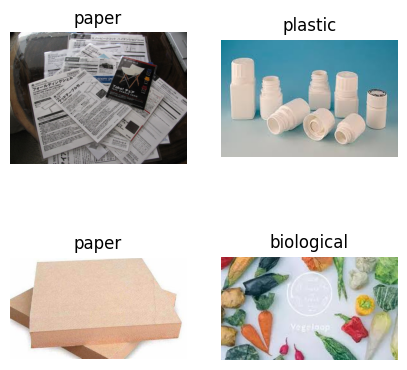

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))  # Display 4 images
axes = axes.ravel()

for i in np.arange(0, 4):
    category = random.choice(os.listdir(train_path))  # Randomly choose a class
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir))  # Randomly choose an image from that class

    img = plt.imread(os.path.join(class_dir, image))
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [24]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Glass: 2431
Metal: 795
Paper: 1315
Trash: 617
Biological: 786
Cardboard: 1446
Plastic: 1528

Total number of train images: 8918


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [25]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [26]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[786, 1446, 2431, 795, 1315, 1528, 617]

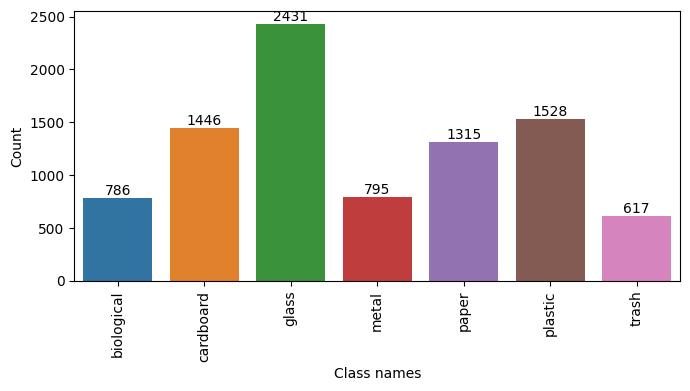

In [27]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

### Class Imbalance in the Dataset

A situation where one or more classes contain a significantly larger number of images is known as **class imbalance**. In our case, this imbalance is expected and reflects the nature of real-world waste distribution. For example:

- **Glass**: 3,039 images  
- **Plastic**: 1,915 images  
- **Cardboard**: 1,810 images  
- **Paper**: 1,650 images  
- **Metal**: 994 images  
- **Biological**: 983 images  
- **Trash**: 772 images  

This imbalance can negatively affect the model’s performance, leading it to favor the larger classes and perform poorly on the underrepresented ones.

To address this issue, we will apply **random undersampling**, a technique that balances the dataset by randomly removing some examples from the overrepresented classes. This helps reduce model bias and improves its ability to generalize across all categories.


Excluding some random images from the training data

In [28]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 1431 in glass
Deleted 0 in metal
Deleted 315 in paper
Deleted 0 in trash
Deleted 0 in biological
Deleted 446 in cardboard
Deleted 528 in plastic


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [29]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

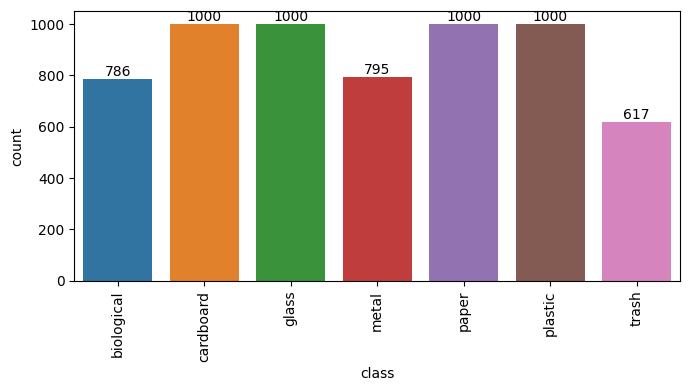

In [30]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [31]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [32]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 442.4967
Mean Height: 417.9622


Let's set the size of the input data (image size) taking into account the found average values

In [33]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [34]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [35]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [36]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 6198 files belonging to 7 classes.


I0000 00:00:1749429691.209995      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749429691.210736      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
[codecarbon INFO @ 00:41:32] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:41:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:32] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 00:41:32] Energy consumed for all GPUs : 0.000616 kWh. Total GPU Power : 26.70510563696019 W
[codecarbon INFO @ 00:41:32] 0.002178 kWh of electricity used since the beginning.


In [37]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 1121 files belonging to 7 classes.


In [38]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 1112 files belonging to 7 classes.


Create directories for train and test logs and write logs to it 

In [39]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [40]:
prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")


[codecarbon INFO @ 00:41:33] Energy consumed for RAM : 0.000505 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:41:33] Delta energy consumed for CPU with constant : 0.000010 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:33] Energy consumed for All CPU : 0.001073 kWh
[codecarbon INFO @ 00:41:33] Energy consumed for all GPUs : 0.000630 kWh. Total GPU Power : 58.82736464838162 W
[codecarbon INFO @ 00:41:33] 0.002208 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.0009992196747308705 kg


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the MobileNet model was selected.


In [41]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon WARNING @ 00:41:33] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:41:33] [setup] RAM Tracking...
[codecarbon INFO @ 00:41:33] [setup] CPU Tracking...
[codecarbon WARNING @ 00:41:34] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:41:34] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:41:34] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 00:41:34] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:41:34] [setup] GPU Tracking...
[codecarbon INFO @ 00:41:34] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:41:34] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Loading the model

In [42]:
base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

/tmp/ipykernel_19/785309607.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False,


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's see what the architecture of the pretrained model looks like

In [43]:
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400, 400, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 200, 200, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 200, 200, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 200, 200, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 200, 200, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 200, 200, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 200, 200, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 201, 201, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 100, 100, 64)        │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 100, 100, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 100, 100, 128)       │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 100, 100, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 100, 100, 128)       │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 100, 100, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 100, 100, 128)       │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [44]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [45]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

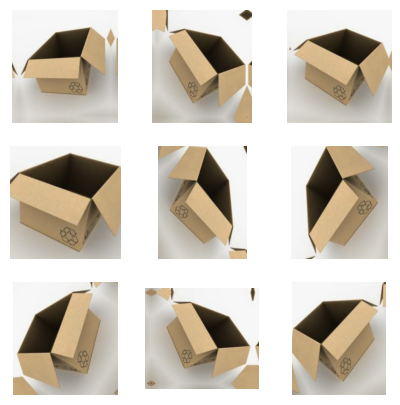

In [46]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [47]:
name="MobileNet"

MobileNet_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [48]:
MobileNet_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [49]:
MobileNet_model.summary()

Model: "MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, None, None, 1024)    │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,360,967 (12.82 MB)

 Trainable params: 132,103 (516.03 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [50]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [51]:
MobileNet_callback = create_callback(name)

Let's set the number of training epochs

In [52]:
EPOCH=20

Let's train the model

In [53]:
import time
start_time = time.time()
MobileNet_history = MobileNet_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=MobileNet_callback)

Epoch 1/20


I0000 00:00:1749429708.013742     216 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/194 ━━━━━━━━━━━━━━━━━━━━ 3:20 1s/step - accuracy: 0.1545 - loss: 2.3623

[codecarbon INFO @ 00:41:52] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:41:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:41:52] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 00:41:52] Energy consumed for all GPUs : 0.000279 kWh. Total GPU Power : 67.01564157949122 W
[codecarbon INFO @ 00:41:52] 0.000540 kWh of electricity used since the beginning.


 19/194 ━━━━━━━━━━━━━━━━━━━━ 2:47 960ms/step - accuracy: 0.2165 - loss: 2.1221

[codecarbon INFO @ 00:42:07] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:07] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 00:42:07] Energy consumed for all GPUs : 0.000678 kWh. Total GPU Power : 95.78606259256568 W
[codecarbon INFO @ 00:42:07] 0.001199 kWh of electricity used since the beginning.


 37/194 ━━━━━━━━━━━━━━━━━━━━ 2:21 903ms/step - accuracy: 0.2511 - loss: 1.9962

[codecarbon INFO @ 00:42:22] Energy consumed for RAM : 0.000250 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:22] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 00:42:22] Energy consumed for all GPUs : 0.001075 kWh. Total GPU Power : 95.25083557227047 W
[codecarbon INFO @ 00:42:22] 0.001856 kWh of electricity used since the beginning.


 55/194 ━━━━━━━━━━━━━━━━━━━━ 2:02 881ms/step - accuracy: 0.2745 - loss: 1.9251

[codecarbon INFO @ 00:42:37] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:37] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 00:42:37] Energy consumed for all GPUs : 0.001470 kWh. Total GPU Power : 94.8689404180821 W
[codecarbon INFO @ 00:42:37] 0.002511 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 1:49 891ms/step - accuracy: 0.2913 - loss: 1.8789

[codecarbon INFO @ 00:42:52] Energy consumed for RAM : 0.000417 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:42:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:42:52] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 00:42:52] Energy consumed for all GPUs : 0.001868 kWh. Total GPU Power : 95.63082215909549 W
[codecarbon INFO @ 00:42:52] 0.003170 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 1:38 909ms/step - accuracy: 0.3031 - loss: 1.8465

[codecarbon INFO @ 00:43:07] Energy consumed for RAM : 0.000500 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:43:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:07] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 00:43:07] Energy consumed for all GPUs : 0.002262 kWh. Total GPU Power : 94.38698350281774 W
[codecarbon INFO @ 00:43:07] 0.003824 kWh of electricity used since the beginning.


102/194 ━━━━━━━━━━━━━━━━━━━━ 1:24 917ms/step - accuracy: 0.3135 - loss: 1.8166

[codecarbon INFO @ 00:43:22] Energy consumed for RAM : 0.000583 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:43:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:22] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 00:43:22] Energy consumed for all GPUs : 0.002653 kWh. Total GPU Power : 93.9325390010235 W
[codecarbon INFO @ 00:43:22] 0.004475 kWh of electricity used since the beginning.


118/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 915ms/step - accuracy: 0.3226 - loss: 1.7905

[codecarbon INFO @ 00:43:37] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:43:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:37] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 00:43:37] Energy consumed for all GPUs : 0.003049 kWh. Total GPU Power : 95.09810286788246 W
[codecarbon INFO @ 00:43:37] 0.005131 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:43:37] 0.019352 g.CO2eq/s mean an estimation of 610.2970870952884 kg.CO2eq/year


136/194 ━━━━━━━━━━━━━━━━━━━━ 52s 903ms/step - accuracy: 0.3325 - loss: 1.7646

[codecarbon INFO @ 00:43:52] Energy consumed for RAM : 0.000750 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:43:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:43:52] Energy consumed for All CPU : 0.001593 kWh


137/194 ━━━━━━━━━━━━━━━━━━━━ 51s 902ms/step - accuracy: 0.3330 - loss: 1.7633

[codecarbon INFO @ 00:43:52] Energy consumed for all GPUs : 0.003444 kWh. Total GPU Power : 94.93254964801855 W
[codecarbon INFO @ 00:43:52] 0.005787 kWh of electricity used since the beginning.


157/194 ━━━━━━━━━━━━━━━━━━━━ 32s 880ms/step - accuracy: 0.3424 - loss: 1.7382

[codecarbon INFO @ 00:44:07] Energy consumed for RAM : 0.000833 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:44:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:07] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 00:44:07] Energy consumed for all GPUs : 0.003841 kWh. Total GPU Power : 95.1512528035329 W
[codecarbon INFO @ 00:44:07] 0.006443 kWh of electricity used since the beginning.


176/194 ━━━━━━━━━━━━━━━━━━━━ 15s 870ms/step - accuracy: 0.3500 - loss: 1.7176

[codecarbon INFO @ 00:44:22] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:44:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:22] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 00:44:22] Energy consumed for all GPUs : 0.004238 kWh. Total GPU Power : 95.51043539083643 W
[codecarbon INFO @ 00:44:22] 0.007102 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.3563 - loss: 1.7007

[codecarbon INFO @ 00:44:37] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:44:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:37] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 00:44:37] Energy consumed for all GPUs : 0.004628 kWh. Total GPU Power : 93.6780123272001 W
[codecarbon INFO @ 00:44:37] 0.007752 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 181s 899ms/step - accuracy: 0.3567 - loss: 1.6998 - val_accuracy: 0.5576 - val_loss: 1.2423 - learning_rate: 0.0010
Epoch 2/20
 10/194 ━━━━━━━━━━━━━━━━━━━━ 2:41 876ms/step - accuracy: 0.5083 - loss: 1.3560

[codecarbon INFO @ 00:44:52] Energy consumed for RAM : 0.001083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:44:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:44:52] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 00:44:52] Energy consumed for all GPUs : 0.005026 kWh. Total GPU Power : 95.49509957771915 W
[codecarbon INFO @ 00:44:52] 0.008410 kWh of electricity used since the beginning.


 28/194 ━━━━━━━━━━━━━━━━━━━━ 2:17 825ms/step - accuracy: 0.5306 - loss: 1.3119

[codecarbon INFO @ 00:45:07] Energy consumed for RAM : 0.001166 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:45:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:07] Energy consumed for All CPU : 0.002478 kWh
[codecarbon INFO @ 00:45:07] Energy consumed for all GPUs : 0.005423 kWh. Total GPU Power : 95.35914750778922 W
[codecarbon INFO @ 00:45:07] 0.009068 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 2:00 819ms/step - accuracy: 0.5310 - loss: 1.3007

[codecarbon INFO @ 00:45:22] Energy consumed for RAM : 0.001249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:45:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:22] Energy consumed for All CPU : 0.002655 kWh
[codecarbon INFO @ 00:45:22] Energy consumed for all GPUs : 0.005822 kWh. Total GPU Power : 95.73092428103591 W
[codecarbon INFO @ 00:45:22] 0.009726 kWh of electricity used since the beginning.


 68/194 ━━━━━━━━━━━━━━━━━━━━ 1:39 788ms/step - accuracy: 0.5322 - loss: 1.2933

[codecarbon INFO @ 00:45:37] Energy consumed for RAM : 0.001333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:45:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:37] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 00:45:37] Energy consumed for all GPUs : 0.006222 kWh. Total GPU Power : 96.01319873053832 W
[codecarbon INFO @ 00:45:37] 0.010386 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:45:37] 0.019821 g.CO2eq/s mean an estimation of 625.0692879257948 kg.CO2eq/year


 90/194 ━━━━━━━━━━━━━━━━━━━━ 1:19 760ms/step - accuracy: 0.5320 - loss: 1.2898

[codecarbon INFO @ 00:45:52] Energy consumed for RAM : 0.001416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:45:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:45:52] Energy consumed for All CPU : 0.003009 kWh
[codecarbon INFO @ 00:45:52] Energy consumed for all GPUs : 0.006621 kWh. Total GPU Power : 95.80337980731551 W
[codecarbon INFO @ 00:45:52] 0.011046 kWh of electricity used since the beginning.


113/194 ━━━━━━━━━━━━━━━━━━━━ 59s 736ms/step - accuracy: 0.5313 - loss: 1.2878 

[codecarbon INFO @ 00:46:07] Energy consumed for RAM : 0.001499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:46:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:07] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 00:46:07] Energy consumed for all GPUs : 0.007020 kWh. Total GPU Power : 95.70833152716094 W
[codecarbon INFO @ 00:46:07] 0.011705 kWh of electricity used since the beginning.


135/194 ━━━━━━━━━━━━━━━━━━━━ 43s 733ms/step - accuracy: 0.5314 - loss: 1.2849

[codecarbon INFO @ 00:46:22] Energy consumed for RAM : 0.001582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:46:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:22] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 00:46:22] Energy consumed for all GPUs : 0.007420 kWh. Total GPU Power : 96.24316662237926 W
[codecarbon INFO @ 00:46:22] 0.012366 kWh of electricity used since the beginning.


158/194 ━━━━━━━━━━━━━━━━━━━━ 25s 718ms/step - accuracy: 0.5321 - loss: 1.2812

[codecarbon INFO @ 00:46:37] Energy consumed for RAM : 0.001666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:46:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:37] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 00:46:37] Energy consumed for all GPUs : 0.007819 kWh. Total GPU Power : 95.78563710817713 W
[codecarbon INFO @ 00:46:37] 0.013025 kWh of electricity used since the beginning.


179/194 ━━━━━━━━━━━━━━━━━━━━ 10s 715ms/step - accuracy: 0.5327 - loss: 1.2782

[codecarbon INFO @ 00:46:52] Energy consumed for RAM : 0.001749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:46:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:46:52] Energy consumed for All CPU : 0.003717 kWh
[codecarbon INFO @ 00:46:52] Energy consumed for all GPUs : 0.008220 kWh. Total GPU Power : 96.1075969118811 W
[codecarbon INFO @ 00:46:52] 0.013686 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 143s 737ms/step - accuracy: 0.5329 - loss: 1.2768 - val_accuracy: 0.6520 - val_loss: 1.0270 - learning_rate: 0.0010
Epoch 3/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 1:10 368ms/step - accuracy: 0.5625 - loss: 1.2028

[codecarbon INFO @ 00:47:07] Energy consumed for RAM : 0.001832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:47:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:07] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 00:47:07] Energy consumed for all GPUs : 0.008616 kWh. Total GPU Power : 95.12811588612551 W
[codecarbon INFO @ 00:47:07] 0.014342 kWh of electricity used since the beginning.


 22/194 ━━━━━━━━━━━━━━━━━━━━ 2:04 721ms/step - accuracy: 0.5552 - loss: 1.1867

[codecarbon INFO @ 00:47:22] Energy consumed for RAM : 0.001916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:47:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:22] Energy consumed for All CPU : 0.004071 kWh
[codecarbon INFO @ 00:47:22] Energy consumed for all GPUs : 0.009015 kWh. Total GPU Power : 95.9272926860601 W
[codecarbon INFO @ 00:47:22] 0.015002 kWh of electricity used since the beginning.


 41/194 ━━━━━━━━━━━━━━━━━━━━ 1:54 749ms/step - accuracy: 0.5611 - loss: 1.1794

[codecarbon INFO @ 00:47:37] Energy consumed for RAM : 0.001999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:47:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:37] Energy consumed for All CPU : 0.004248 kWh
[codecarbon INFO @ 00:47:37] Energy consumed for all GPUs : 0.009417 kWh. Total GPU Power : 96.57434629780715 W
[codecarbon INFO @ 00:47:37] 0.015664 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:47:37] 0.019905 g.CO2eq/s mean an estimation of 627.7328302802007 kg.CO2eq/year


 62/194 ━━━━━━━━━━━━━━━━━━━━ 1:38 743ms/step - accuracy: 0.5608 - loss: 1.1787

[codecarbon INFO @ 00:47:52] Energy consumed for RAM : 0.002082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:47:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:47:52] Energy consumed for All CPU : 0.004425 kWh
[codecarbon INFO @ 00:47:52] Energy consumed for all GPUs : 0.009817 kWh. Total GPU Power : 96.05493426341792 W
[codecarbon INFO @ 00:47:52] 0.016324 kWh of electricity used since the beginning.


 83/194 ━━━━━━━━━━━━━━━━━━━━ 1:21 735ms/step - accuracy: 0.5610 - loss: 1.1797

[codecarbon INFO @ 00:48:07] Energy consumed for RAM : 0.002165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:48:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:07] Energy consumed for All CPU : 0.004602 kWh
[codecarbon INFO @ 00:48:07] Energy consumed for all GPUs : 0.010217 kWh. Total GPU Power : 95.9453760183046 W
[codecarbon INFO @ 00:48:07] 0.016984 kWh of electricity used since the beginning.


105/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 724ms/step - accuracy: 0.5608 - loss: 1.1819

[codecarbon INFO @ 00:48:22] Energy consumed for RAM : 0.002249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:48:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:22] Energy consumed for All CPU : 0.004779 kWh
[codecarbon INFO @ 00:48:22] Energy consumed for all GPUs : 0.010620 kWh. Total GPU Power : 96.75767257302553 W
[codecarbon INFO @ 00:48:22] 0.017648 kWh of electricity used since the beginning.


129/194 ━━━━━━━━━━━━━━━━━━━━ 45s 706ms/step - accuracy: 0.5603 - loss: 1.1835

[codecarbon INFO @ 00:48:37] Energy consumed for RAM : 0.002332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:48:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:37] Energy consumed for All CPU : 0.004956 kWh
[codecarbon INFO @ 00:48:37] Energy consumed for all GPUs : 0.011020 kWh. Total GPU Power : 96.0034228288791 W
[codecarbon INFO @ 00:48:37] 0.018308 kWh of electricity used since the beginning.


154/194 ━━━━━━━━━━━━━━━━━━━━ 27s 688ms/step - accuracy: 0.5598 - loss: 1.1852

[codecarbon INFO @ 00:48:52] Energy consumed for RAM : 0.002415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:48:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:48:52] Energy consumed for All CPU : 0.005133 kWh
[codecarbon INFO @ 00:48:52] Energy consumed for all GPUs : 0.011420 kWh. Total GPU Power : 96.17296781961471 W
[codecarbon INFO @ 00:48:52] 0.018969 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 9s 673ms/step - accuracy: 0.5598 - loss: 1.1862 

[codecarbon INFO @ 00:49:07] Energy consumed for RAM : 0.002499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:49:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:07] Energy consumed for All CPU : 0.005310 kWh
[codecarbon INFO @ 00:49:07] Energy consumed for all GPUs : 0.011822 kWh. Total GPU Power : 96.47927412329574 W
[codecarbon INFO @ 00:49:07] 0.019631 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 135s 699ms/step - accuracy: 0.5597 - loss: 1.1870 - val_accuracy: 0.6259 - val_loss: 1.0832 - learning_rate: 0.0010
Epoch 4/20


[codecarbon INFO @ 00:49:22] Energy consumed for RAM : 0.002582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:49:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:22] Energy consumed for All CPU : 0.005487 kWh
[codecarbon INFO @ 00:49:22] Energy consumed for all GPUs : 0.012222 kWh. Total GPU Power : 95.84673660788538 W
[codecarbon INFO @ 00:49:22] 0.020290 kWh of electricity used since the beginning.


 23/194 ━━━━━━━━━━━━━━━━━━━━ 1:47 630ms/step - accuracy: 0.6455 - loss: 1.0386

[codecarbon INFO @ 00:49:37] Energy consumed for RAM : 0.002665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:49:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:37] Energy consumed for All CPU : 0.005664 kWh
[codecarbon INFO @ 00:49:37] Energy consumed for all GPUs : 0.012623 kWh. Total GPU Power : 96.32057631600412 W
[codecarbon INFO @ 00:49:37] 0.020952 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:49:37] 0.019944 g.CO2eq/s mean an estimation of 628.9495379932131 kg.CO2eq/year


 49/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 610ms/step - accuracy: 0.6361 - loss: 1.0516

[codecarbon INFO @ 00:49:52] Energy consumed for RAM : 0.002748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:49:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:49:52] Energy consumed for All CPU : 0.005841 kWh
[codecarbon INFO @ 00:49:52] Energy consumed for all GPUs : 0.013025 kWh. Total GPU Power : 96.61966895606722 W
[codecarbon INFO @ 00:49:52] 0.021614 kWh of electricity used since the beginning.


 70/194 ━━━━━━━━━━━━━━━━━━━━ 1:19 638ms/step - accuracy: 0.6310 - loss: 1.0562

[codecarbon INFO @ 00:50:07] Energy consumed for RAM : 0.002832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:50:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:07] Energy consumed for All CPU : 0.006018 kWh
[codecarbon INFO @ 00:50:07] Energy consumed for all GPUs : 0.013427 kWh. Total GPU Power : 96.43737356432757 W
[codecarbon INFO @ 00:50:07] 0.022276 kWh of electricity used since the beginning.


 96/194 ━━━━━━━━━━━━━━━━━━━━ 1:01 624ms/step - accuracy: 0.6255 - loss: 1.0635

[codecarbon INFO @ 00:50:22] Energy consumed for RAM : 0.002915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:50:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:22] Energy consumed for All CPU : 0.006195 kWh
[codecarbon INFO @ 00:50:22] Energy consumed for all GPUs : 0.013829 kWh. Total GPU Power : 96.55812892474516 W
[codecarbon INFO @ 00:50:22] 0.022939 kWh of electricity used since the beginning.


125/194 ━━━━━━━━━━━━━━━━━━━━ 41s 596ms/step - accuracy: 0.6205 - loss: 1.0718

[codecarbon INFO @ 00:50:37] Energy consumed for RAM : 0.002998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:50:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:37] Energy consumed for All CPU : 0.006372 kWh
[codecarbon INFO @ 00:50:37] Energy consumed for all GPUs : 0.014231 kWh. Total GPU Power : 96.4682288423456 W
[codecarbon INFO @ 00:50:37] 0.023601 kWh of electricity used since the beginning.


152/194 ━━━━━━━━━━━━━━━━━━━━ 24s 591ms/step - accuracy: 0.6170 - loss: 1.0765

[codecarbon INFO @ 00:50:52] Energy consumed for RAM : 0.003082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:50:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:50:52] Energy consumed for All CPU : 0.006549 kWh
[codecarbon INFO @ 00:50:52] Energy consumed for all GPUs : 0.014632 kWh. Total GPU Power : 96.40019140789069 W
[codecarbon INFO @ 00:50:52] 0.024262 kWh of electricity used since the beginning.


177/194 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.6145 - loss: 1.0802

[codecarbon INFO @ 00:51:07] Energy consumed for RAM : 0.003165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:51:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:07] Energy consumed for All CPU : 0.006726 kWh
[codecarbon INFO @ 00:51:07] Energy consumed for all GPUs : 0.015035 kWh. Total GPU Power : 96.66589204119701 W
[codecarbon INFO @ 00:51:07] 0.024925 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.6129 - loss: 1.0827

[codecarbon INFO @ 00:51:22] Energy consumed for RAM : 0.003248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:51:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:22] Energy consumed for All CPU : 0.006903 kWh


194/194 ━━━━━━━━━━━━━━━━━━━━ 121s 620ms/step - accuracy: 0.6128 - loss: 1.0828 - val_accuracy: 0.6565 - val_loss: 0.9596 - learning_rate: 0.0010
Epoch 5/20


[codecarbon INFO @ 00:51:22] Energy consumed for all GPUs : 0.015435 kWh. Total GPU Power : 95.98808746284965 W
[codecarbon INFO @ 00:51:22] 0.025586 kWh of electricity used since the beginning.


 26/194 ━━━━━━━━━━━━━━━━━━━━ 1:34 563ms/step - accuracy: 0.6336 - loss: 1.0504

[codecarbon INFO @ 00:51:37] Energy consumed for RAM : 0.003331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:51:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:37] Energy consumed for All CPU : 0.007080 kWh
[codecarbon INFO @ 00:51:37] Energy consumed for all GPUs : 0.015835 kWh. Total GPU Power : 96.31896914386502 W
[codecarbon INFO @ 00:51:37] 0.026246 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:51:37] 0.019970 g.CO2eq/s mean an estimation of 629.77595450482 kg.CO2eq/year


 53/194 ━━━━━━━━━━━━━━━━━━━━ 1:20 569ms/step - accuracy: 0.6227 - loss: 1.0672

[codecarbon INFO @ 00:51:52] Energy consumed for RAM : 0.003415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:51:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:51:52] Energy consumed for All CPU : 0.007257 kWh
[codecarbon INFO @ 00:51:52] Energy consumed for all GPUs : 0.016240 kWh. Total GPU Power : 97.01920644956765 W
[codecarbon INFO @ 00:51:52] 0.026911 kWh of electricity used since the beginning.


 80/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 566ms/step - accuracy: 0.6201 - loss: 1.0672

[codecarbon INFO @ 00:52:07] Energy consumed for RAM : 0.003498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:52:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:07] Energy consumed for All CPU : 0.007434 kWh
[codecarbon INFO @ 00:52:07] Energy consumed for all GPUs : 0.016641 kWh. Total GPU Power : 96.47930706996257 W
[codecarbon INFO @ 00:52:07] 0.027573 kWh of electricity used since the beginning.


106/194 ━━━━━━━━━━━━━━━━━━━━ 49s 568ms/step - accuracy: 0.6175 - loss: 1.0706

[codecarbon INFO @ 00:52:22] Energy consumed for RAM : 0.003581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:52:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:22] Energy consumed for All CPU : 0.007611 kWh
[codecarbon INFO @ 00:52:22] Energy consumed for all GPUs : 0.017043 kWh. Total GPU Power : 96.36626614590041 W
[codecarbon INFO @ 00:52:22] 0.028234 kWh of electricity used since the beginning.


135/194 ━━━━━━━━━━━━━━━━━━━━ 32s 555ms/step - accuracy: 0.6159 - loss: 1.0717

[codecarbon INFO @ 00:52:37] Energy consumed for RAM : 0.003664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:52:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:37] Energy consumed for All CPU : 0.007788 kWh
[codecarbon INFO @ 00:52:37] Energy consumed for all GPUs : 0.017446 kWh. Total GPU Power : 96.9498841939918 W
[codecarbon INFO @ 00:52:37] 0.028898 kWh of electricity used since the beginning.


164/194 ━━━━━━━━━━━━━━━━━━━━ 16s 549ms/step - accuracy: 0.6151 - loss: 1.0713

[codecarbon INFO @ 00:52:52] Energy consumed for RAM : 0.003748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:52:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:52:52] Energy consumed for All CPU : 0.007965 kWh
[codecarbon INFO @ 00:52:52] Energy consumed for all GPUs : 0.017849 kWh. Total GPU Power : 96.534236746534 W
[codecarbon INFO @ 00:52:52] 0.029561 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 2s 554ms/step - accuracy: 0.6144 - loss: 1.0722

[codecarbon INFO @ 00:53:07] Energy consumed for RAM : 0.003831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:53:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:07] Energy consumed for All CPU : 0.008142 kWh
[codecarbon INFO @ 00:53:07] Energy consumed for all GPUs : 0.018251 kWh. Total GPU Power : 96.65972680132367 W
[codecarbon INFO @ 00:53:07] 0.030224 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 113s 582ms/step - accuracy: 0.6141 - loss: 1.0727 - val_accuracy: 0.6592 - val_loss: 0.9523 - learning_rate: 0.0010
Epoch 6/20
 15/194 ━━━━━━━━━━━━━━━━━━━━ 1:27 489ms/step - accuracy: 0.5980 - loss: 1.0652

[codecarbon INFO @ 00:53:22] Energy consumed for RAM : 0.003914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:53:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:22] Energy consumed for All CPU : 0.008319 kWh
[codecarbon INFO @ 00:53:22] Energy consumed for all GPUs : 0.018654 kWh. Total GPU Power : 96.61052943968332 W
[codecarbon INFO @ 00:53:22] 0.030886 kWh of electricity used since the beginning.


 45/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 499ms/step - accuracy: 0.6069 - loss: 1.0684

[codecarbon INFO @ 00:53:37] Energy consumed for RAM : 0.003998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:53:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:37] Energy consumed for All CPU : 0.008495 kWh
[codecarbon INFO @ 00:53:37] Energy consumed for all GPUs : 0.019055 kWh. Total GPU Power : 96.41855967943889 W
[codecarbon INFO @ 00:53:37] 0.031548 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:53:37] 0.019996 g.CO2eq/s mean an estimation of 630.5897043997535 kg.CO2eq/year


 73/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 514ms/step - accuracy: 0.6135 - loss: 1.0622

[codecarbon INFO @ 00:53:52] Energy consumed for RAM : 0.004081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:53:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:53:52] Energy consumed for All CPU : 0.008673 kWh
[codecarbon INFO @ 00:53:52] Energy consumed for all GPUs : 0.019460 kWh. Total GPU Power : 97.15274727020996 W
[codecarbon INFO @ 00:53:52] 0.032213 kWh of electricity used since the beginning.


 95/194 ━━━━━━━━━━━━━━━━━━━━ 53s 545ms/step - accuracy: 0.6156 - loss: 1.0619

[codecarbon INFO @ 00:54:07] Energy consumed for RAM : 0.004164 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:54:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:07] Energy consumed for All CPU : 0.008849 kWh


 96/194 ━━━━━━━━━━━━━━━━━━━━ 53s 548ms/step - accuracy: 0.6157 - loss: 1.0620

[codecarbon INFO @ 00:54:07] Energy consumed for all GPUs : 0.019863 kWh. Total GPU Power : 96.93050806335518 W
[codecarbon INFO @ 00:54:07] 0.032877 kWh of electricity used since the beginning.


122/194 ━━━━━━━━━━━━━━━━━━━━ 39s 550ms/step - accuracy: 0.6165 - loss: 1.0632

[codecarbon INFO @ 00:54:22] Energy consumed for RAM : 0.004247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:54:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:22] Energy consumed for All CPU : 0.009026 kWh
[codecarbon INFO @ 00:54:22] Energy consumed for all GPUs : 0.020266 kWh. Total GPU Power : 96.6118637436441 W
[codecarbon INFO @ 00:54:22] 0.033539 kWh of electricity used since the beginning.


149/194 ━━━━━━━━━━━━━━━━━━━━ 24s 549ms/step - accuracy: 0.6169 - loss: 1.0631

[codecarbon INFO @ 00:54:37] Energy consumed for RAM : 0.004331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:54:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:37] Energy consumed for All CPU : 0.009203 kWh
[codecarbon INFO @ 00:54:37] Energy consumed for all GPUs : 0.020671 kWh. Total GPU Power : 97.31507663745501 W
[codecarbon INFO @ 00:54:37] 0.034204 kWh of electricity used since the beginning.


180/194 ━━━━━━━━━━━━━━━━━━━━ 7s 542ms/step - accuracy: 0.6168 - loss: 1.0634

[codecarbon INFO @ 00:54:52] Energy consumed for RAM : 0.004414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:54:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:54:52] Energy consumed for All CPU : 0.009380 kWh
[codecarbon INFO @ 00:54:52] Energy consumed for all GPUs : 0.021073 kWh. Total GPU Power : 96.59995014261128 W
[codecarbon INFO @ 00:54:52] 0.034867 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 110s 567ms/step - accuracy: 0.6165 - loss: 1.0641 - val_accuracy: 0.6628 - val_loss: 0.9314 - learning_rate: 0.0010
Epoch 7/20
  4/194 ━━━━━━━━━━━━━━━━━━━━ 1:37 513ms/step - accuracy: 0.6126 - loss: 1.0136

[codecarbon INFO @ 00:55:07] Energy consumed for RAM : 0.004497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:55:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:07] Energy consumed for All CPU : 0.009557 kWh
[codecarbon INFO @ 00:55:07] Energy consumed for all GPUs : 0.021475 kWh. Total GPU Power : 96.6531434708674 W
[codecarbon INFO @ 00:55:07] 0.035530 kWh of electricity used since the beginning.


 31/194 ━━━━━━━━━━━━━━━━━━━━ 1:29 547ms/step - accuracy: 0.6314 - loss: 0.9813

[codecarbon INFO @ 00:55:22] Energy consumed for RAM : 0.004580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:55:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:22] Energy consumed for All CPU : 0.009734 kWh
[codecarbon INFO @ 00:55:22] Energy consumed for all GPUs : 0.021880 kWh. Total GPU Power : 97.05254787985879 W
[codecarbon INFO @ 00:55:22] 0.036194 kWh of electricity used since the beginning.


 65/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 492ms/step - accuracy: 0.6377 - loss: 0.9760

[codecarbon INFO @ 00:55:37] Energy consumed for RAM : 0.004664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:55:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:37] Energy consumed for All CPU : 0.009911 kWh
[codecarbon INFO @ 00:55:37] Energy consumed for all GPUs : 0.022282 kWh. Total GPU Power : 96.68245905975107 W
[codecarbon INFO @ 00:55:37] 0.036857 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:55:37] 0.020023 g.CO2eq/s mean an estimation of 631.4360235205614 kg.CO2eq/year


 95/194 ━━━━━━━━━━━━━━━━━━━━ 49s 497ms/step - accuracy: 0.6384 - loss: 0.9806

[codecarbon INFO @ 00:55:52] Energy consumed for RAM : 0.004747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:55:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:55:52] Energy consumed for All CPU : 0.010088 kWh
[codecarbon INFO @ 00:55:52] Energy consumed for all GPUs : 0.022685 kWh. Total GPU Power : 96.8030898402143 W
[codecarbon INFO @ 00:55:52] 0.037520 kWh of electricity used since the beginning.


128/194 ━━━━━━━━━━━━━━━━━━━━ 32s 487ms/step - accuracy: 0.6377 - loss: 0.9855

[codecarbon INFO @ 00:56:07] Energy consumed for RAM : 0.004830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:56:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:07] Energy consumed for All CPU : 0.010265 kWh
[codecarbon INFO @ 00:56:07] Energy consumed for all GPUs : 0.023090 kWh. Total GPU Power : 97.12346832533989 W
[codecarbon INFO @ 00:56:07] 0.038185 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step - accuracy: 0.6371 - loss: 0.9892

[codecarbon INFO @ 00:56:22] Energy consumed for RAM : 0.004913 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:56:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:22] Energy consumed for All CPU : 0.010442 kWh
[codecarbon INFO @ 00:56:22] Energy consumed for all GPUs : 0.023493 kWh. Total GPU Power : 96.80949900126339 W
[codecarbon INFO @ 00:56:22] 0.038849 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.6361 - loss: 0.9928

[codecarbon INFO @ 00:56:37] Energy consumed for RAM : 0.004997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:56:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:37] Energy consumed for All CPU : 0.010619 kWh
[codecarbon INFO @ 00:56:37] Energy consumed for all GPUs : 0.023895 kWh. Total GPU Power : 96.47789180552189 W
[codecarbon INFO @ 00:56:37] 0.039511 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 97s 498ms/step - accuracy: 0.6360 - loss: 0.9929 - val_accuracy: 0.6547 - val_loss: 0.9429 - learning_rate: 0.0010
Epoch 8/20
 25/194 ━━━━━━━━━━━━━━━━━━━━ 1:06 395ms/step - accuracy: 0.6505 - loss: 0.9760

[codecarbon INFO @ 00:56:52] Energy consumed for RAM : 0.005080 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:56:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:56:52] Energy consumed for All CPU : 0.010796 kWh
[codecarbon INFO @ 00:56:52] Energy consumed for all GPUs : 0.024299 kWh. Total GPU Power : 97.065551459708 W
[codecarbon INFO @ 00:56:52] 0.040175 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 52s 395ms/step - accuracy: 0.6509 - loss: 0.9704

[codecarbon INFO @ 00:57:07] Energy consumed for RAM : 0.005163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:57:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:07] Energy consumed for All CPU : 0.010973 kWh
[codecarbon INFO @ 00:57:07] Energy consumed for all GPUs : 0.024702 kWh. Total GPU Power : 96.75075764848107 W
[codecarbon INFO @ 00:57:07] 0.040838 kWh of electricity used since the beginning.


 96/194 ━━━━━━━━━━━━━━━━━━━━ 40s 415ms/step - accuracy: 0.6508 - loss: 0.9730

[codecarbon INFO @ 00:57:22] Energy consumed for RAM : 0.005247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:57:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:22] Energy consumed for All CPU : 0.011150 kWh
[codecarbon INFO @ 00:57:22] Energy consumed for all GPUs : 0.025104 kWh. Total GPU Power : 96.64344747534572 W
[codecarbon INFO @ 00:57:22] 0.041501 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 28s 430ms/step - accuracy: 0.6479 - loss: 0.9792

[codecarbon INFO @ 00:57:37] Energy consumed for RAM : 0.005330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:57:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:37] Energy consumed for All CPU : 0.011327 kWh
[codecarbon INFO @ 00:57:37] Energy consumed for all GPUs : 0.025509 kWh. Total GPU Power : 97.29901222233799 W
[codecarbon INFO @ 00:57:37] 0.042166 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:57:37] 0.020023 g.CO2eq/s mean an estimation of 631.4517474363336 kg.CO2eq/year


160/194 ━━━━━━━━━━━━━━━━━━━━ 14s 434ms/step - accuracy: 0.6460 - loss: 0.9825

[codecarbon INFO @ 00:57:52] Energy consumed for RAM : 0.005413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:57:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:57:52] Energy consumed for All CPU : 0.011504 kWh


161/194 ━━━━━━━━━━━━━━━━━━━━ 14s 435ms/step - accuracy: 0.6459 - loss: 0.9825

[codecarbon INFO @ 00:57:52] Energy consumed for all GPUs : 0.025911 kWh. Total GPU Power : 96.49087444139585 W
[codecarbon INFO @ 00:57:52] 0.042828 kWh of electricity used since the beginning.


192/194 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.6449 - loss: 0.9848

[codecarbon INFO @ 00:58:07] Energy consumed for RAM : 0.005496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:58:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:07] Energy consumed for All CPU : 0.011681 kWh


193/194 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6449 - loss: 0.9849

[codecarbon INFO @ 00:58:07] Energy consumed for all GPUs : 0.026316 kWh. Total GPU Power : 97.31596093131192 W
[codecarbon INFO @ 00:58:07] 0.043494 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 92s 469ms/step - accuracy: 0.6448 - loss: 0.9851 - val_accuracy: 0.6628 - val_loss: 0.9093 - learning_rate: 0.0010
Epoch 9/20
 20/194 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - accuracy: 0.6566 - loss: 0.9765

[codecarbon INFO @ 00:58:22] Energy consumed for RAM : 0.005580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:58:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:22] Energy consumed for All CPU : 0.011858 kWh
[codecarbon INFO @ 00:58:22] Energy consumed for all GPUs : 0.026719 kWh. Total GPU Power : 96.70877101796468 W
[codecarbon INFO @ 00:58:22] 0.044157 kWh of electricity used since the beginning.


 55/194 ━━━━━━━━━━━━━━━━━━━━ 1:01 439ms/step - accuracy: 0.6649 - loss: 0.9505

[codecarbon INFO @ 00:58:37] Energy consumed for RAM : 0.005663 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:58:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:37] Energy consumed for All CPU : 0.012035 kWh
[codecarbon INFO @ 00:58:37] Energy consumed for all GPUs : 0.027122 kWh. Total GPU Power : 96.60333010657489 W
[codecarbon INFO @ 00:58:37] 0.044819 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 53s 476ms/step - accuracy: 0.6626 - loss: 0.9519

[codecarbon INFO @ 00:58:52] Energy consumed for RAM : 0.005746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:58:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:58:52] Energy consumed for All CPU : 0.012212 kWh
[codecarbon INFO @ 00:58:52] Energy consumed for all GPUs : 0.027527 kWh. Total GPU Power : 97.3151324096436 W
[codecarbon INFO @ 00:58:52] 0.045485 kWh of electricity used since the beginning.


116/194 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - accuracy: 0.6565 - loss: 0.9653

[codecarbon INFO @ 00:59:07] Energy consumed for RAM : 0.005829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:59:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:07] Energy consumed for All CPU : 0.012389 kWh
[codecarbon INFO @ 00:59:07] Energy consumed for all GPUs : 0.027929 kWh. Total GPU Power : 96.57225804785806 W
[codecarbon INFO @ 00:59:07] 0.046147 kWh of electricity used since the beginning.


153/194 ━━━━━━━━━━━━━━━━━━━━ 18s 452ms/step - accuracy: 0.6522 - loss: 0.9749

[codecarbon INFO @ 00:59:22] Energy consumed for RAM : 0.005913 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:59:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:22] Energy consumed for All CPU : 0.012566 kWh
[codecarbon INFO @ 00:59:22] Energy consumed for all GPUs : 0.028334 kWh. Total GPU Power : 97.17782186470093 W
[codecarbon INFO @ 00:59:22] 0.046812 kWh of electricity used since the beginning.


184/194 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.6500 - loss: 0.9796

[codecarbon INFO @ 00:59:37] Energy consumed for RAM : 0.005996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:59:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:37] Energy consumed for All CPU : 0.012743 kWh
[codecarbon INFO @ 00:59:37] Energy consumed for all GPUs : 0.028738 kWh. Total GPU Power : 96.9081112725728 W
[codecarbon INFO @ 00:59:37] 0.047476 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:59:37] 0.020028 g.CO2eq/s mean an estimation of 631.6139074181797 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 95s 490ms/step - accuracy: 0.6491 - loss: 0.9814 - val_accuracy: 0.6924 - val_loss: 0.8847 - learning_rate: 0.0010
Epoch 10/20
  9/194 ━━━━━━━━━━━━━━━━━━━━ 1:16 414ms/step - accuracy: 0.6677 - loss: 0.9985

[codecarbon INFO @ 00:59:52] Energy consumed for RAM : 0.006079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:59:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:59:52] Energy consumed for All CPU : 0.012920 kWh
[codecarbon INFO @ 00:59:52] Energy consumed for all GPUs : 0.029138 kWh. Total GPU Power : 96.2822238196222 W
[codecarbon INFO @ 00:59:52] 0.048137 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 1:06 442ms/step - accuracy: 0.6337 - loss: 0.9899

[codecarbon INFO @ 01:00:07] Energy consumed for RAM : 0.006163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:00:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:07] Energy consumed for All CPU : 0.013097 kWh
[codecarbon INFO @ 01:00:07] Energy consumed for all GPUs : 0.029544 kWh. Total GPU Power : 97.28536000737854 W
[codecarbon INFO @ 01:00:07] 0.048803 kWh of electricity used since the beginning.


 75/194 ━━━━━━━━━━━━━━━━━━━━ 53s 450ms/step - accuracy: 0.6314 - loss: 0.9884

[codecarbon INFO @ 01:00:22] Energy consumed for RAM : 0.006246 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:00:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:22] Energy consumed for All CPU : 0.013274 kWh
[codecarbon INFO @ 01:00:22] Energy consumed for all GPUs : 0.029946 kWh. Total GPU Power : 96.7228172573828 W
[codecarbon INFO @ 01:00:22] 0.049466 kWh of electricity used since the beginning.


115/194 ━━━━━━━━━━━━━━━━━━━━ 33s 425ms/step - accuracy: 0.6313 - loss: 0.9878

[codecarbon INFO @ 01:00:37] Energy consumed for RAM : 0.006329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:00:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:37] Energy consumed for All CPU : 0.013451 kWh
[codecarbon INFO @ 01:00:37] Energy consumed for all GPUs : 0.030352 kWh. Total GPU Power : 97.40929418526026 W
[codecarbon INFO @ 01:00:37] 0.050132 kWh of electricity used since the beginning.


149/194 ━━━━━━━━━━━━━━━━━━━━ 19s 429ms/step - accuracy: 0.6318 - loss: 0.9868

[codecarbon INFO @ 01:00:52] Energy consumed for RAM : 0.006412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:00:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:00:52] Energy consumed for All CPU : 0.013628 kWh
[codecarbon INFO @ 01:00:52] Energy consumed for all GPUs : 0.030756 kWh. Total GPU Power : 96.9994611950965 W
[codecarbon INFO @ 01:00:52] 0.050796 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step - accuracy: 0.6323 - loss: 0.9872

[codecarbon INFO @ 01:01:07] Energy consumed for RAM : 0.006496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:01:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:07] Energy consumed for All CPU : 0.013805 kWh
[codecarbon INFO @ 01:01:07] Energy consumed for all GPUs : 0.031159 kWh. Total GPU Power : 96.68859240254078 W
[codecarbon INFO @ 01:01:07] 0.051459 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 88s 455ms/step - accuracy: 0.6324 - loss: 0.9880 - val_accuracy: 0.6646 - val_loss: 0.8970 - learning_rate: 0.0010
Epoch 11/20
 13/194 ━━━━━━━━━━━━━━━━━━━━ 1:16 421ms/step - accuracy: 0.6328 - loss: 0.9905

[codecarbon INFO @ 01:01:22] Energy consumed for RAM : 0.006579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:01:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:22] Energy consumed for All CPU : 0.013981 kWh
[codecarbon INFO @ 01:01:22] Energy consumed for all GPUs : 0.031562 kWh. Total GPU Power : 96.8690329264432 W
[codecarbon INFO @ 01:01:22] 0.052123 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 430ms/step - accuracy: 0.6544 - loss: 0.9473

[codecarbon INFO @ 01:01:37] Energy consumed for RAM : 0.006662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:01:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:37] Energy consumed for All CPU : 0.014158 kWh
[codecarbon INFO @ 01:01:37] Energy consumed for all GPUs : 0.031965 kWh. Total GPU Power : 96.77619913500926 W
[codecarbon INFO @ 01:01:37] 0.052785 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:01:37] 0.020026 g.CO2eq/s mean an estimation of 631.5249457926235 kg.CO2eq/year


 84/194 ━━━━━━━━━━━━━━━━━━━━ 46s 419ms/step - accuracy: 0.6584 - loss: 0.9386

[codecarbon INFO @ 01:01:52] Energy consumed for RAM : 0.006745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:01:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:01:52] Energy consumed for All CPU : 0.014335 kWh
[codecarbon INFO @ 01:01:52] Energy consumed for all GPUs : 0.032369 kWh. Total GPU Power : 97.03739566239742 W
[codecarbon INFO @ 01:01:52] 0.053450 kWh of electricity used since the beginning.


122/194 ━━━━━━━━━━━━━━━━━━━━ 29s 414ms/step - accuracy: 0.6573 - loss: 0.9444

[codecarbon INFO @ 01:02:07] Energy consumed for RAM : 0.006829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:02:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:07] Energy consumed for All CPU : 0.014512 kWh
[codecarbon INFO @ 01:02:07] Energy consumed for all GPUs : 0.032774 kWh. Total GPU Power : 97.14508133397064 W
[codecarbon INFO @ 01:02:07] 0.054115 kWh of electricity used since the beginning.


160/194 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.6566 - loss: 0.9480

[codecarbon INFO @ 01:02:22] Energy consumed for RAM : 0.006912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:02:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:22] Energy consumed for All CPU : 0.014689 kWh
[codecarbon INFO @ 01:02:22] Energy consumed for all GPUs : 0.033176 kWh. Total GPU Power : 96.589325537922 W
[codecarbon INFO @ 01:02:22] 0.054777 kWh of electricity used since the beginning.


191/194 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - accuracy: 0.6560 - loss: 0.9500

[codecarbon INFO @ 01:02:37] Energy consumed for RAM : 0.006995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:02:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:37] Energy consumed for All CPU : 0.014866 kWh
[codecarbon INFO @ 01:02:37] Energy consumed for all GPUs : 0.033581 kWh. Total GPU Power : 97.34787981912761 W
[codecarbon INFO @ 01:02:37] 0.055443 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6560 - loss: 0.9502
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
194/194 ━━━━━━━━━━━━━━━━━━━━ 88s 450ms/step - accuracy: 0.6559 - loss: 0.9503 - val_accuracy: 0.6682 - val_loss: 0.9204 - learning_rate: 0.0010
Epoch 12/20
 19/194 ━━━━━━━━━━━━━━━━━━━━ 1:13 419ms/step - accuracy: 0.6138 - loss: 0.9990

[codecarbon INFO @ 01:02:52] Energy consumed for RAM : 0.007078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:02:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:02:52] Energy consumed for All CPU : 0.015043 kWh
[codecarbon INFO @ 01:02:52] Energy consumed for all GPUs : 0.033983 kWh. Total GPU Power : 96.511457005624 W
[codecarbon INFO @ 01:02:52] 0.056105 kWh of electricity used since the beginning.


 52/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 439ms/step - accuracy: 0.6463 - loss: 0.9489

[codecarbon INFO @ 01:03:07] Energy consumed for RAM : 0.007162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:03:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:07] Energy consumed for All CPU : 0.015220 kWh
[codecarbon INFO @ 01:03:07] Energy consumed for all GPUs : 0.034387 kWh. Total GPU Power : 96.92462832509193 W
[codecarbon INFO @ 01:03:07] 0.056769 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - accuracy: 0.6562 - loss: 0.9302

[codecarbon INFO @ 01:03:22] Energy consumed for RAM : 0.007245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:03:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:22] Energy consumed for All CPU : 0.015397 kWh
[codecarbon INFO @ 01:03:22] Energy consumed for all GPUs : 0.034792 kWh. Total GPU Power : 97.22195081655104 W
[codecarbon INFO @ 01:03:22] 0.057434 kWh of electricity used since the beginning.


130/194 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.6592 - loss: 0.9263

[codecarbon INFO @ 01:03:37] Energy consumed for RAM : 0.007328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:03:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:37] Energy consumed for All CPU : 0.015574 kWh
[codecarbon INFO @ 01:03:37] Energy consumed for all GPUs : 0.035194 kWh. Total GPU Power : 96.59296986738303 W
[codecarbon INFO @ 01:03:37] 0.058097 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:03:37] 0.020032 g.CO2eq/s mean an estimation of 631.7222732665317 kg.CO2eq/year


170/194 ━━━━━━━━━━━━━━━━━━━━ 9s 399ms/step - accuracy: 0.6624 - loss: 0.9202

[codecarbon INFO @ 01:03:52] Energy consumed for RAM : 0.007412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:03:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:03:52] Energy consumed for All CPU : 0.015751 kWh
[codecarbon INFO @ 01:03:52] Energy consumed for all GPUs : 0.035599 kWh. Total GPU Power : 97.18284519414233 W
[codecarbon INFO @ 01:03:52] 0.058762 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.6631 - loss: 0.9189

[codecarbon INFO @ 01:04:07] Energy consumed for RAM : 0.007495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:04:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:07] Energy consumed for All CPU : 0.015928 kWh
[codecarbon INFO @ 01:04:07] Energy consumed for all GPUs : 0.036002 kWh. Total GPU Power : 96.6625450337317 W
[codecarbon INFO @ 01:04:07] 0.059425 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 86s 442ms/step - accuracy: 0.6631 - loss: 0.9188 - val_accuracy: 0.6942 - val_loss: 0.8398 - learning_rate: 2.0000e-04
Epoch 13/20
 26/194 ━━━━━━━━━━━━━━━━━━━━ 1:18 467ms/step - accuracy: 0.6969 - loss: 0.8694

[codecarbon INFO @ 01:04:22] Energy consumed for RAM : 0.007578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:04:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:22] Energy consumed for All CPU : 0.016105 kWh
[codecarbon INFO @ 01:04:22] Energy consumed for all GPUs : 0.036403 kWh. Total GPU Power : 96.46420556521349 W
[codecarbon INFO @ 01:04:22] 0.060086 kWh of electricity used since the beginning.


 66/194 ━━━━━━━━━━━━━━━━━━━━ 52s 407ms/step - accuracy: 0.6986 - loss: 0.8644

[codecarbon INFO @ 01:04:37] Energy consumed for RAM : 0.007661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:04:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:37] Energy consumed for All CPU : 0.016282 kWh
[codecarbon INFO @ 01:04:37] Energy consumed for all GPUs : 0.036807 kWh. Total GPU Power : 97.01622871032208 W
[codecarbon INFO @ 01:04:37] 0.060751 kWh of electricity used since the beginning.


100/194 ━━━━━━━━━━━━━━━━━━━━ 39s 415ms/step - accuracy: 0.6963 - loss: 0.8650

[codecarbon INFO @ 01:04:52] Energy consumed for RAM : 0.007745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:04:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:04:52] Energy consumed for All CPU : 0.016459 kWh
[codecarbon INFO @ 01:04:52] Energy consumed for all GPUs : 0.037209 kWh. Total GPU Power : 96.47383066373263 W
[codecarbon INFO @ 01:04:52] 0.061413 kWh of electricity used since the beginning.


141/194 ━━━━━━━━━━━━━━━━━━━━ 21s 402ms/step - accuracy: 0.6925 - loss: 0.8716

[codecarbon INFO @ 01:05:07] Energy consumed for RAM : 0.007828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:05:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:07] Energy consumed for All CPU : 0.016636 kWh
[codecarbon INFO @ 01:05:07] Energy consumed for all GPUs : 0.037612 kWh. Total GPU Power : 96.68150099930824 W
[codecarbon INFO @ 01:05:07] 0.062076 kWh of electricity used since the beginning.


188/194 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - accuracy: 0.6910 - loss: 0.8742

[codecarbon INFO @ 01:05:22] Energy consumed for RAM : 0.007911 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:05:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:22] Energy consumed for All CPU : 0.016813 kWh
[codecarbon INFO @ 01:05:22] Energy consumed for all GPUs : 0.038015 kWh. Total GPU Power : 96.81521328044346 W
[codecarbon INFO @ 01:05:22] 0.062739 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 407ms/step - accuracy: 0.6907 - loss: 0.8747 - val_accuracy: 0.6915 - val_loss: 0.8379 - learning_rate: 2.0000e-04
Epoch 14/20
 16/194 ━━━━━━━━━━━━━━━━━━━━ 1:26 484ms/step - accuracy: 0.6360 - loss: 0.9668

[codecarbon INFO @ 01:05:37] Energy consumed for RAM : 0.007994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:05:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:37] Energy consumed for All CPU : 0.016990 kWh


 17/194 ━━━━━━━━━━━━━━━━━━━━ 1:24 479ms/step - accuracy: 0.6380 - loss: 0.9632

[codecarbon INFO @ 01:05:37] Energy consumed for all GPUs : 0.038417 kWh. Total GPU Power : 96.69388244869272 W
[codecarbon INFO @ 01:05:37] 0.063402 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:05:37] 0.020008 g.CO2eq/s mean an estimation of 630.9660100900295 kg.CO2eq/year


 56/194 ━━━━━━━━━━━━━━━━━━━━ 56s 411ms/step - accuracy: 0.6706 - loss: 0.9030

[codecarbon INFO @ 01:05:52] Energy consumed for RAM : 0.008078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:05:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:05:52] Energy consumed for All CPU : 0.017167 kWh
[codecarbon INFO @ 01:05:52] Energy consumed for all GPUs : 0.038820 kWh. Total GPU Power : 96.75090663037257 W
[codecarbon INFO @ 01:05:52] 0.064065 kWh of electricity used since the beginning.


 97/194 ━━━━━━━━━━━━━━━━━━━━ 37s 391ms/step - accuracy: 0.6759 - loss: 0.8897

[codecarbon INFO @ 01:06:07] Energy consumed for RAM : 0.008161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:06:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:07] Energy consumed for All CPU : 0.017344 kWh
[codecarbon INFO @ 01:06:07] Energy consumed for all GPUs : 0.039224 kWh. Total GPU Power : 97.07739064031142 W
[codecarbon INFO @ 01:06:07] 0.064729 kWh of electricity used since the beginning.


140/194 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - accuracy: 0.6750 - loss: 0.8892

[codecarbon INFO @ 01:06:22] Energy consumed for RAM : 0.008244 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:06:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:22] Energy consumed for All CPU : 0.017521 kWh
[codecarbon INFO @ 01:06:22] Energy consumed for all GPUs : 0.039628 kWh. Total GPU Power : 96.86652482026257 W
[codecarbon INFO @ 01:06:22] 0.065393 kWh of electricity used since the beginning.


178/194 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step - accuracy: 0.6754 - loss: 0.8882

[codecarbon INFO @ 01:06:37] Energy consumed for RAM : 0.008328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:06:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:37] Energy consumed for All CPU : 0.017698 kWh
[codecarbon INFO @ 01:06:37] Energy consumed for all GPUs : 0.040032 kWh. Total GPU Power : 96.96670422460616 W
[codecarbon INFO @ 01:06:37] 0.066057 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 80s 412ms/step - accuracy: 0.6751 - loss: 0.8889 - val_accuracy: 0.6942 - val_loss: 0.8430 - learning_rate: 2.0000e-04
Epoch 15/20
  5/194 ━━━━━━━━━━━━━━━━━━━━ 1:44 550ms/step - accuracy: 0.6314 - loss: 0.8524

[codecarbon INFO @ 01:06:52] Energy consumed for RAM : 0.008411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:06:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:06:52] Energy consumed for All CPU : 0.017875 kWh
[codecarbon INFO @ 01:06:52] Energy consumed for all GPUs : 0.040434 kWh. Total GPU Power : 96.5383122031872 W
[codecarbon INFO @ 01:06:52] 0.066719 kWh of electricity used since the beginning.


 43/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 418ms/step - accuracy: 0.6767 - loss: 0.8573

[codecarbon INFO @ 01:07:07] Energy consumed for RAM : 0.008494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:07:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:07] Energy consumed for All CPU : 0.018052 kWh
[codecarbon INFO @ 01:07:07] Energy consumed for all GPUs : 0.040837 kWh. Total GPU Power : 96.71629930712172 W
[codecarbon INFO @ 01:07:07] 0.067382 kWh of electricity used since the beginning.


 86/194 ━━━━━━━━━━━━━━━━━━━━ 41s 384ms/step - accuracy: 0.6849 - loss: 0.8568

[codecarbon INFO @ 01:07:22] Energy consumed for RAM : 0.008577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:07:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:22] Energy consumed for All CPU : 0.018229 kWh
[codecarbon INFO @ 01:07:22] Energy consumed for all GPUs : 0.041240 kWh. Total GPU Power : 96.92839017020385 W
[codecarbon INFO @ 01:07:22] 0.068046 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step - accuracy: 0.6833 - loss: 0.8650

[codecarbon INFO @ 01:07:37] Energy consumed for RAM : 0.008661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:07:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:37] Energy consumed for All CPU : 0.018406 kWh
[codecarbon INFO @ 01:07:37] Energy consumed for all GPUs : 0.041643 kWh. Total GPU Power : 96.72307816680825 W
[codecarbon INFO @ 01:07:37] 0.068709 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:07:37] 0.020019 g.CO2eq/s mean an estimation of 631.3331120376699 kg.CO2eq/year


164/194 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - accuracy: 0.6823 - loss: 0.8691

[codecarbon INFO @ 01:07:52] Energy consumed for RAM : 0.008744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:07:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:07:52] Energy consumed for All CPU : 0.018583 kWh
[codecarbon INFO @ 01:07:52] Energy consumed for all GPUs : 0.042045 kWh. Total GPU Power : 96.58681759795218 W
[codecarbon INFO @ 01:07:52] 0.069372 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 78s 401ms/step - accuracy: 0.6815 - loss: 0.8723 - val_accuracy: 0.6960 - val_loss: 0.8365 - learning_rate: 2.0000e-04
Epoch 16/20


[codecarbon INFO @ 01:08:07] Energy consumed for RAM : 0.008827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:08:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:07] Energy consumed for All CPU : 0.018760 kWh
[codecarbon INFO @ 01:08:07] Energy consumed for all GPUs : 0.042447 kWh. Total GPU Power : 96.48955928029653 W
[codecarbon INFO @ 01:08:07] 0.070034 kWh of electricity used since the beginning.


 39/194 ━━━━━━━━━━━━━━━━━━━━ 59s 382ms/step - accuracy: 0.7074 - loss: 0.8504 

[codecarbon INFO @ 01:08:22] Energy consumed for RAM : 0.008910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:08:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:22] Energy consumed for All CPU : 0.018937 kWh
[codecarbon INFO @ 01:08:22] Energy consumed for all GPUs : 0.042851 kWh. Total GPU Power : 96.83695839045645 W
[codecarbon INFO @ 01:08:22] 0.070698 kWh of electricity used since the beginning.


 75/194 ━━━━━━━━━━━━━━━━━━━━ 47s 397ms/step - accuracy: 0.7032 - loss: 0.8513

[codecarbon INFO @ 01:08:37] Energy consumed for RAM : 0.008994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:08:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:37] Energy consumed for All CPU : 0.019113 kWh
[codecarbon INFO @ 01:08:37] Energy consumed for all GPUs : 0.043255 kWh. Total GPU Power : 97.28882194953962 W
[codecarbon INFO @ 01:08:37] 0.071363 kWh of electricity used since the beginning.


116/194 ━━━━━━━━━━━━━━━━━━━━ 30s 387ms/step - accuracy: 0.6955 - loss: 0.8607

[codecarbon INFO @ 01:08:52] Energy consumed for RAM : 0.009077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:08:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:08:52] Energy consumed for All CPU : 0.019290 kWh
[codecarbon INFO @ 01:08:52] Energy consumed for all GPUs : 0.043658 kWh. Total GPU Power : 96.74148176279016 W
[codecarbon INFO @ 01:08:52] 0.072026 kWh of electricity used since the beginning.


156/194 ━━━━━━━━━━━━━━━━━━━━ 14s 384ms/step - accuracy: 0.6911 - loss: 0.8668

[codecarbon INFO @ 01:09:07] Energy consumed for RAM : 0.009160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:09:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:07] Energy consumed for All CPU : 0.019467 kWh
[codecarbon INFO @ 01:09:07] Energy consumed for all GPUs : 0.044061 kWh. Total GPU Power : 96.60156558559314 W
[codecarbon INFO @ 01:09:07] 0.072688 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6887 - loss: 0.8707

[codecarbon INFO @ 01:09:22] Energy consumed for RAM : 0.009243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:09:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:22] Energy consumed for All CPU : 0.019644 kWh
[codecarbon INFO @ 01:09:22] Energy consumed for all GPUs : 0.044465 kWh. Total GPU Power : 97.04639383739078 W
[codecarbon INFO @ 01:09:22] 0.073353 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 408ms/step - accuracy: 0.6887 - loss: 0.8708 - val_accuracy: 0.6987 - val_loss: 0.8297 - learning_rate: 2.0000e-04
Epoch 17/20
 21/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 362ms/step - accuracy: 0.6604 - loss: 0.9031

[codecarbon INFO @ 01:09:37] Energy consumed for RAM : 0.009327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:09:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:37] Energy consumed for All CPU : 0.019821 kWh
[codecarbon INFO @ 01:09:37] Energy consumed for all GPUs : 0.044847 kWh. Total GPU Power : 91.81307163709273 W
[codecarbon INFO @ 01:09:37] 0.073995 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:09:37] 0.019938 g.CO2eq/s mean an estimation of 628.7554927433457 kg.CO2eq/year


 59/194 ━━━━━━━━━━━━━━━━━━━━ 52s 390ms/step - accuracy: 0.6808 - loss: 0.8723

[codecarbon INFO @ 01:09:52] Energy consumed for RAM : 0.009410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:09:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:09:52] Energy consumed for All CPU : 0.019998 kWh
[codecarbon INFO @ 01:09:52] Energy consumed for all GPUs : 0.045251 kWh. Total GPU Power : 96.94183738526226 W
[codecarbon INFO @ 01:09:52] 0.074659 kWh of electricity used since the beginning.


 96/194 ━━━━━━━━━━━━━━━━━━━━ 38s 397ms/step - accuracy: 0.6837 - loss: 0.8666

[codecarbon INFO @ 01:10:07] Energy consumed for RAM : 0.009493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:10:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:07] Energy consumed for All CPU : 0.020175 kWh
[codecarbon INFO @ 01:10:07] Energy consumed for all GPUs : 0.045654 kWh. Total GPU Power : 96.75360563364629 W
[codecarbon INFO @ 01:10:07] 0.075323 kWh of electricity used since the beginning.


139/194 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - accuracy: 0.6826 - loss: 0.8709

[codecarbon INFO @ 01:10:22] Energy consumed for RAM : 0.009577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:10:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:22] Energy consumed for All CPU : 0.020352 kWh
[codecarbon INFO @ 01:10:22] Energy consumed for all GPUs : 0.046058 kWh. Total GPU Power : 96.93601604320529 W
[codecarbon INFO @ 01:10:22] 0.075987 kWh of electricity used since the beginning.


183/194 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - accuracy: 0.6827 - loss: 0.8717

[codecarbon INFO @ 01:10:37] Energy consumed for RAM : 0.009660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:10:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:37] Energy consumed for All CPU : 0.020529 kWh
[codecarbon INFO @ 01:10:37] Energy consumed for all GPUs : 0.046461 kWh. Total GPU Power : 96.73323978489728 W
[codecarbon INFO @ 01:10:37] 0.076650 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 80s 398ms/step - accuracy: 0.6825 - loss: 0.8722 - val_accuracy: 0.7041 - val_loss: 0.8210 - learning_rate: 2.0000e-04
Epoch 18/20
 16/194 ━━━━━━━━━━━━━━━━━━━━ 56s 318ms/step - accuracy: 0.6765 - loss: 0.8631

[codecarbon INFO @ 01:10:52] Energy consumed for RAM : 0.009743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:10:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:10:52] Energy consumed for All CPU : 0.020706 kWh
[codecarbon INFO @ 01:10:52] Energy consumed for all GPUs : 0.046863 kWh. Total GPU Power : 96.65861308107138 W
[codecarbon INFO @ 01:10:52] 0.077312 kWh of electricity used since the beginning.


 56/194 ━━━━━━━━━━━━━━━━━━━━ 49s 361ms/step - accuracy: 0.6898 - loss: 0.8486

[codecarbon INFO @ 01:11:07] Energy consumed for RAM : 0.009826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:07] Energy consumed for All CPU : 0.020883 kWh
[codecarbon INFO @ 01:11:07] Energy consumed for all GPUs : 0.047267 kWh. Total GPU Power : 97.06028447195771 W
[codecarbon INFO @ 01:11:07] 0.077977 kWh of electricity used since the beginning.


 98/194 ━━━━━━━━━━━━━━━━━━━━ 34s 359ms/step - accuracy: 0.6932 - loss: 0.8492

[codecarbon INFO @ 01:11:22] Energy consumed for RAM : 0.009910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:22] Energy consumed for All CPU : 0.021060 kWh
[codecarbon INFO @ 01:11:22] Energy consumed for all GPUs : 0.047670 kWh. Total GPU Power : 96.75199947276171 W
[codecarbon INFO @ 01:11:22] 0.078640 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.6912 - loss: 0.8542

[codecarbon INFO @ 01:11:37] Energy consumed for RAM : 0.009993 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:37] Energy consumed for All CPU : 0.021237 kWh
[codecarbon INFO @ 01:11:37] Energy consumed for all GPUs : 0.048074 kWh. Total GPU Power : 97.05585248649216 W
[codecarbon INFO @ 01:11:37] 0.079304 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:11:37] 0.020024 g.CO2eq/s mean an estimation of 631.4741162367899 kg.CO2eq/year


186/194 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - accuracy: 0.6901 - loss: 0.8561

[codecarbon INFO @ 01:11:52] Energy consumed for RAM : 0.010076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:11:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:11:52] Energy consumed for All CPU : 0.021414 kWh
[codecarbon INFO @ 01:11:52] Energy consumed for all GPUs : 0.048477 kWh. Total GPU Power : 96.75465023048655 W
[codecarbon INFO @ 01:11:52] 0.079968 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 74s 380ms/step - accuracy: 0.6897 - loss: 0.8567 - val_accuracy: 0.7032 - val_loss: 0.8239 - learning_rate: 2.0000e-04
Epoch 19/20
 20/194 ━━━━━━━━━━━━━━━━━━━━ 56s 327ms/step - accuracy: 0.7055 - loss: 0.8843

[codecarbon INFO @ 01:12:07] Energy consumed for RAM : 0.010160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:07] Energy consumed for All CPU : 0.021591 kWh
[codecarbon INFO @ 01:12:07] Energy consumed for all GPUs : 0.048879 kWh. Total GPU Power : 96.4229821034822 W
[codecarbon INFO @ 01:12:07] 0.080629 kWh of electricity used since the beginning.


 64/194 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - accuracy: 0.7106 - loss: 0.8536

[codecarbon INFO @ 01:12:22] Energy consumed for RAM : 0.010243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:22] Energy consumed for All CPU : 0.021768 kWh
[codecarbon INFO @ 01:12:22] Energy consumed for all GPUs : 0.049283 kWh. Total GPU Power : 97.08211624775775 W
[codecarbon INFO @ 01:12:22] 0.081294 kWh of electricity used since the beginning.


103/194 ━━━━━━━━━━━━━━━━━━━━ 32s 355ms/step - accuracy: 0.7058 - loss: 0.8504

[codecarbon INFO @ 01:12:37] Energy consumed for RAM : 0.010326 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:37] Energy consumed for All CPU : 0.021945 kWh
[codecarbon INFO @ 01:12:37] Energy consumed for all GPUs : 0.049686 kWh. Total GPU Power : 96.79617043157238 W
[codecarbon INFO @ 01:12:37] 0.081957 kWh of electricity used since the beginning.


143/194 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.7016 - loss: 0.8514

[codecarbon INFO @ 01:12:52] Energy consumed for RAM : 0.010409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:12:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:12:52] Energy consumed for All CPU : 0.022122 kWh
[codecarbon INFO @ 01:12:52] Energy consumed for all GPUs : 0.050091 kWh. Total GPU Power : 97.01993161915757 W
[codecarbon INFO @ 01:12:52] 0.082622 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.6992 - loss: 0.8519

[codecarbon INFO @ 01:13:07] Energy consumed for RAM : 0.010493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:07] Energy consumed for All CPU : 0.022299 kWh
[codecarbon INFO @ 01:13:07] Energy consumed for all GPUs : 0.050494 kWh. Total GPU Power : 96.98860413709804 W
[codecarbon INFO @ 01:13:07] 0.083286 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 74s 382ms/step - accuracy: 0.6989 - loss: 0.8521 - val_accuracy: 0.7077 - val_loss: 0.8143 - learning_rate: 2.0000e-04
Epoch 20/20
 21/194 ━━━━━━━━━━━━━━━━━━━━ 1:00 349ms/step - accuracy: 0.6912 - loss: 0.8860

[codecarbon INFO @ 01:13:22] Energy consumed for RAM : 0.010576 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:22] Energy consumed for All CPU : 0.022476 kWh
[codecarbon INFO @ 01:13:22] Energy consumed for all GPUs : 0.050894 kWh. Total GPU Power : 96.01366639978576 W
[codecarbon INFO @ 01:13:22] 0.083946 kWh of electricity used since the beginning.


 66/194 ━━━━━━━━━━━━━━━━━━━━ 43s 340ms/step - accuracy: 0.6981 - loss: 0.8671

[codecarbon INFO @ 01:13:37] Energy consumed for RAM : 0.010659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:37] Energy consumed for All CPU : 0.022653 kWh
[codecarbon INFO @ 01:13:37] Energy consumed for all GPUs : 0.051299 kWh. Total GPU Power : 97.07993360034688 W
[codecarbon INFO @ 01:13:37] 0.084611 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:13:37] 0.020014 g.CO2eq/s mean an estimation of 631.1754479790891 kg.CO2eq/year


116/194 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.6944 - loss: 0.8678

[codecarbon INFO @ 01:13:52] Energy consumed for RAM : 0.010743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:13:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:13:52] Energy consumed for All CPU : 0.022830 kWh
[codecarbon INFO @ 01:13:52] Energy consumed for all GPUs : 0.051701 kWh. Total GPU Power : 96.71514015895391 W
[codecarbon INFO @ 01:13:52] 0.085274 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.6921 - loss: 0.8686

[codecarbon INFO @ 01:14:07] Energy consumed for RAM : 0.010826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:07] Energy consumed for All CPU : 0.023007 kWh
[codecarbon INFO @ 01:14:07] Energy consumed for all GPUs : 0.052103 kWh. Total GPU Power : 96.4631077178997 W
[codecarbon INFO @ 01:14:07] 0.085936 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6910 - loss: 0.8689

[codecarbon INFO @ 01:14:22] Energy consumed for RAM : 0.010909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:22] Energy consumed for All CPU : 0.023184 kWh
[codecarbon INFO @ 01:14:22] Energy consumed for all GPUs : 0.052507 kWh. Total GPU Power : 96.99164474589043 W
[codecarbon INFO @ 01:14:22] 0.086600 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 70s 358ms/step - accuracy: 0.6910 - loss: 0.8690 - val_accuracy: 0.6924 - val_loss: 0.8409 - learning_rate: 2.0000e-04


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [54]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [55]:
end_time = time.time()
training_time = end_time - start_time
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
print("Total training time: {:.2f} seconds".format(training_time))
MobileNet_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 01:14:26] Energy consumed for RAM : 0.010931 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 01:14:26] Delta energy consumed for CPU with constant : 0.000047 kWh, power : 42.5 W
[codecarbon INFO @ 01:14:26] Energy consumed for All CPU : 0.023231 kWh
[codecarbon INFO @ 01:14:26] Energy consumed for all GPUs : 0.052600 kWh. Total GPU Power : 84.12609817070641 W
[codecarbon INFO @ 01:14:26] 0.086762 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.03927028311772569 kg
Total training time: 1964.27 seconds


Close the SummaryWriter

In [56]:
writer.close()
train_writer.close()
test_writer.close()

In [57]:
MobileNet_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [58]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

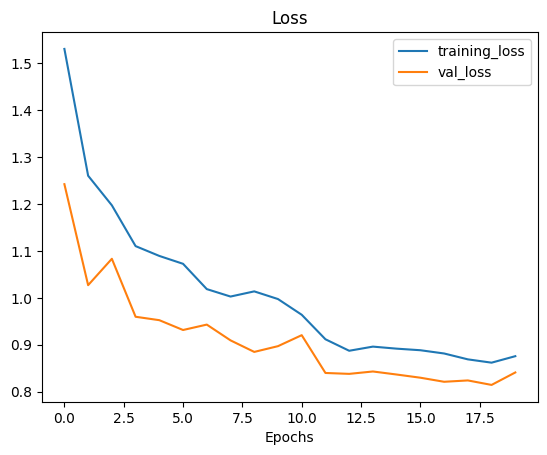

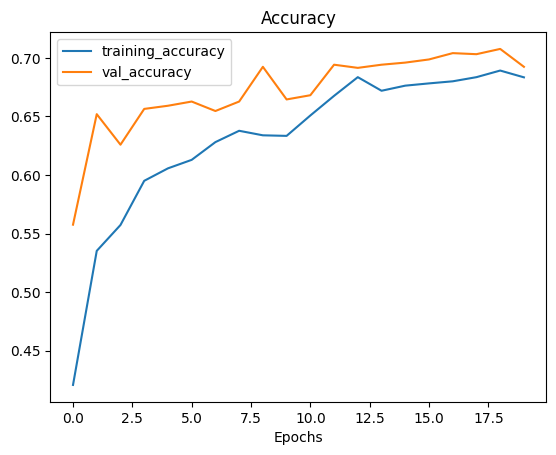

In [59]:
plot_loss_curves(MobileNet_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [60]:
test_loss, test_accuracy = MobileNet_model.evaluate(test_data, verbose=0)

In [61]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.88641
Test Accuracy: 68.42%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [62]:
pred_probs = MobileNet_model.predict(test_data, verbose=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step


In [63]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [65]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

  biological       0.82      0.87      0.84        99
   cardboard       0.85      0.77      0.81       182
       glass       0.87      0.54      0.67       305
       metal       0.41      0.78      0.53       100
       paper       0.63      0.73      0.68       165
     plastic       0.69      0.66      0.67       192
       trash       0.52      0.63      0.57        78

    accuracy                           0.68      1121
   macro avg       0.68      0.71      0.68      1121
weighted avg       0.73      0.68      0.69      1121



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [66]:
import itertools

In [67]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

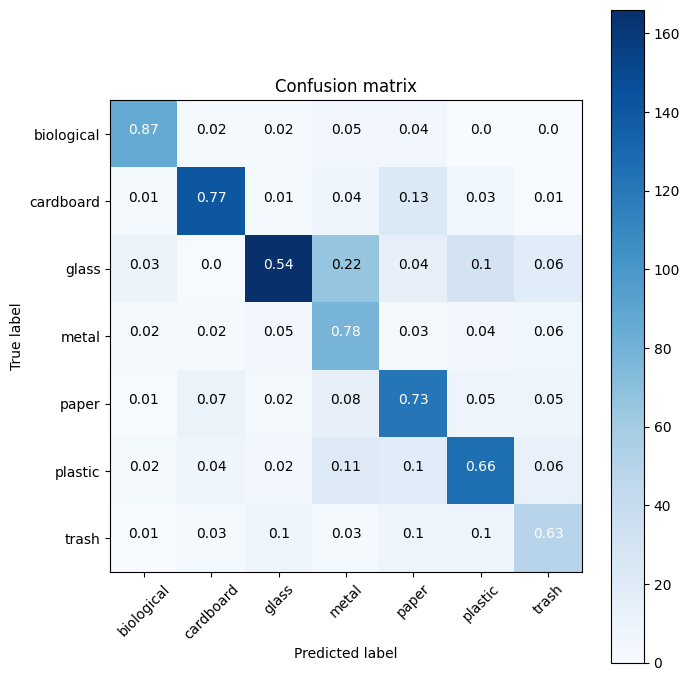

In [68]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [69]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon WARNING @ 01:14:56] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:14:56] [setup] RAM Tracking...
[codecarbon INFO @ 01:14:56] [setup] CPU Tracking...
[codecarbon WARNING @ 01:14:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 01:14:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 01:14:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 01:14:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 01:14:57] [setup] GPU Tracking...
[codecarbon INFO @ 01:14:57] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:14:57] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Deploy Model Carbon Emissions: 0.04093932057484747 kg


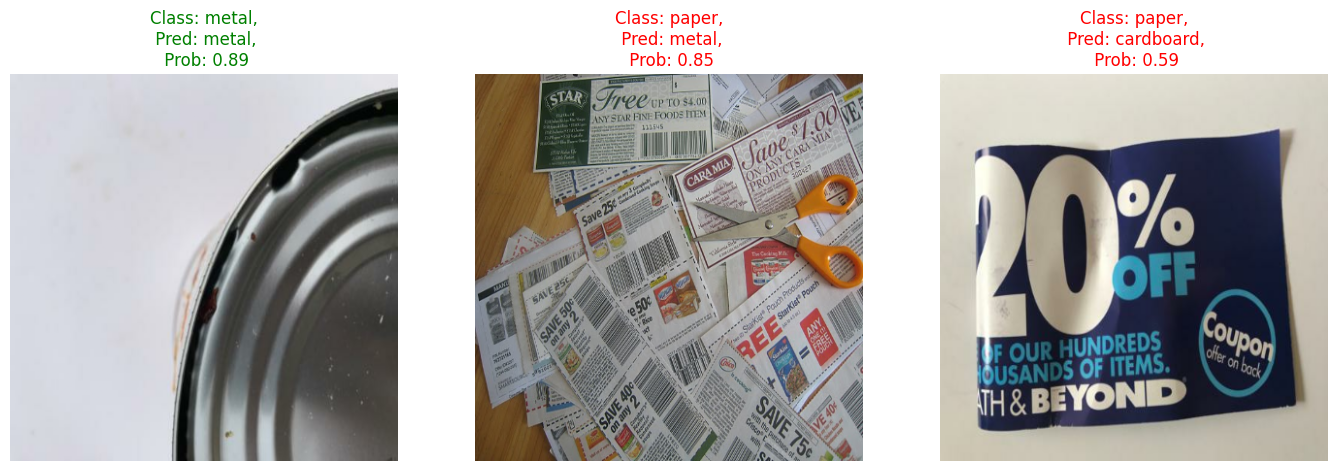

In [70]:
pred_random_images(MobileNet_model, test_path, class_names)

In [71]:
import pickle
pickle.dump(MobileNet_model,open("MobileNet_model.h5","wb"))

In [72]:
ls ../working

data/                      logs/         MobileNet_model.h5
emissions.csv              logs.zip      __notebook__.ipynb
garbage-classification.h5  MobileNet.h5  runs/
